<a href="https://colab.research.google.com/github/Bigulac/MOAR/blob/main/MOAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Следећи код представља конволутивну неуралну мрежу која је истренирана да разликује слике паса и мачака.

In [16]:
import os
import numpy as np
import keras
import tensorflow as tf
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

In [3]:
# Skida dataset sa interneta
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -q kagglecatsanddogs_5340.zip


# Izbacuje slike koje su oštećene ili nečitljive proverom da li ima JFIF tag u zapisu
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Brisanje slika
            os.remove(fpath)
print(f"Deleted {num_skipped} images.")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  86.1M      0  0:00:09  0:00:09 --:--:--  110M
Deleted 1590 images.


Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


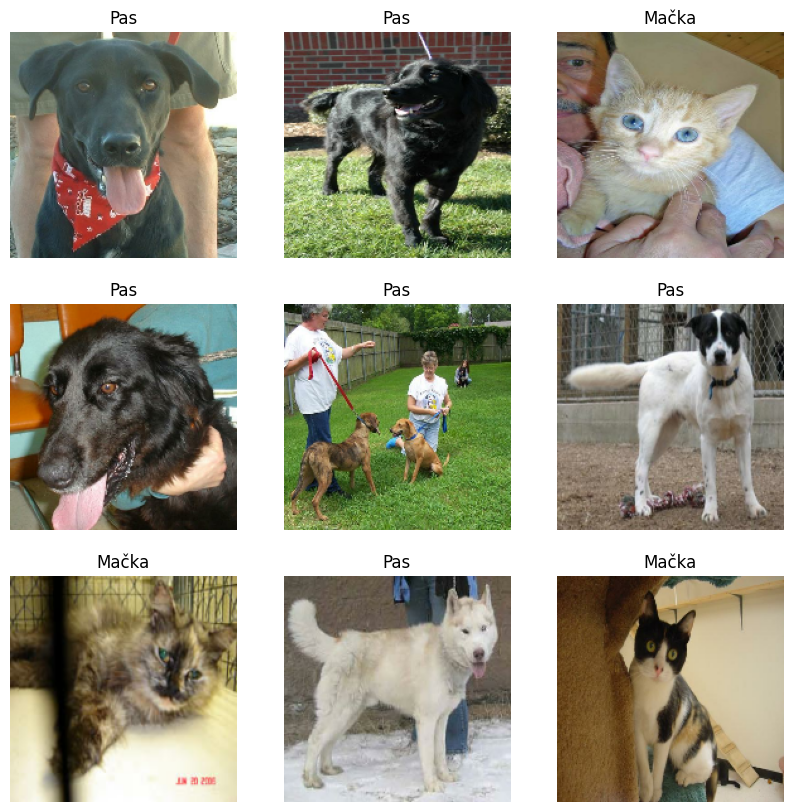

In [4]:
# Definisanje dimenzija slika i veličine
image_size = (180, 180)
batch_size = 128

# Pravi skup slika za treninranje modela i validaciju
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

# Prikaz slika iz dataseta
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title("Pas" if int(labels[i]) else "Mačka")
        plt.axis("off")

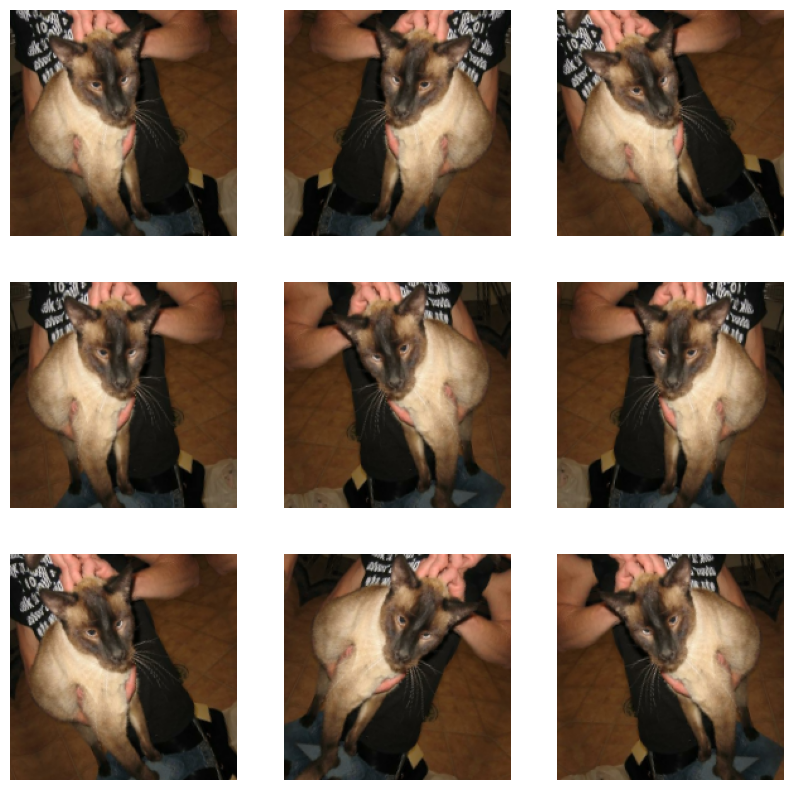

In [5]:
# Povećanje skupa malim modifikacijama postojećih slika
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

# Prikaz kako izgledaju slike nakon modifikacija
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

# Primena gornje funkcije na trening skup
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)


**Model**

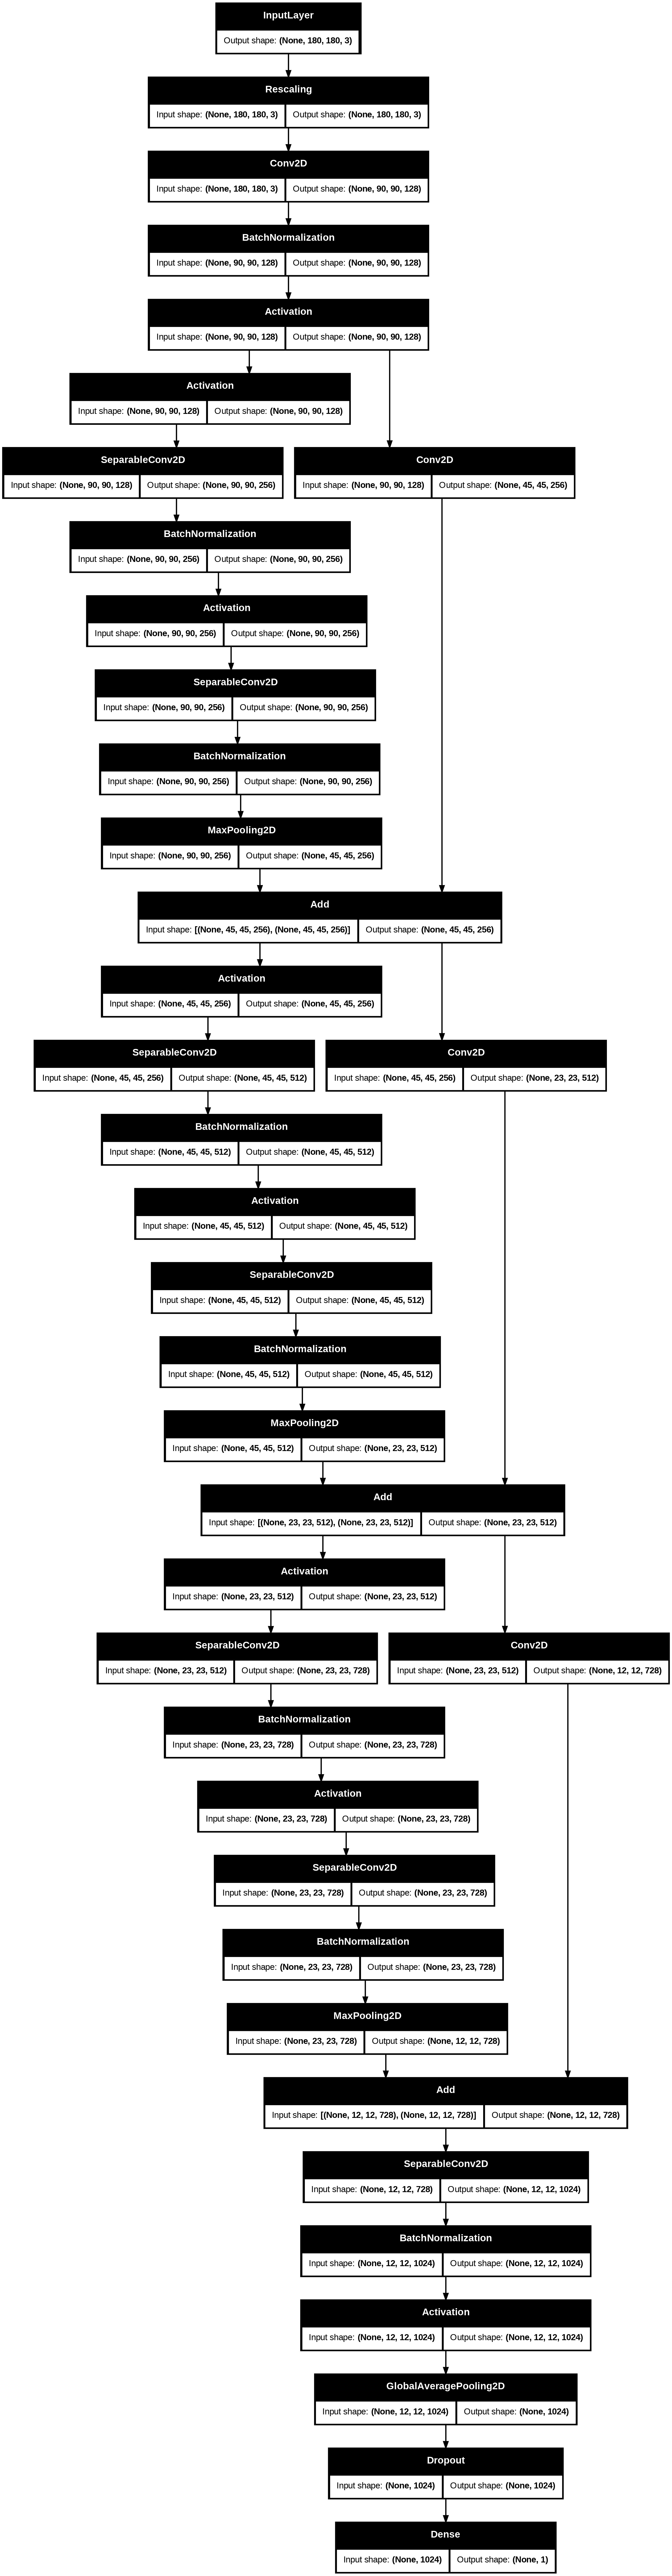

In [6]:
# Priprema resursa za treniranje na GPU
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

# Funkcija za pravljenje modela
def make_model(input_shape, num_classes):

    # Ovde slika ulazi u model
    inputs = keras.Input(shape=input_shape)

    # Ulazni sloj
    x = layers.Rescaling(1.0 / 255)(inputs) # normalizacija slike
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x) # Aktivaciona funkcija za unošenje nelinearnosti

    previous_block_activation = x  # Rezultat prvog sloja, potreban za residualne slojeve

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Aktivacija residualnih slojeva
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])
        previous_block_activation = x  # Sledeći residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)

    # Izlazni sloj
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)

# Kreiranje modela
model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

Treniranje modela i rezultati

In [7]:

# Treniranje modela
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

# Čuvanje napretka radi iscrtavanja grafika
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)


Epoch 1/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 331s 2s/step - acc: 0.6324 - loss: 0.6359 - val_acc: 0.4957 - val_loss: 0.7028
Epoch 2/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 245s 1s/step - acc: 0.7525 - loss: 0.4871 - val_acc: 0.4957 - val_loss: 0.7098
Epoch 3/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - acc: 0.8168 - loss: 0.3871 - val_acc: 0.4957 - val_loss: 0.6949
Epoch 4/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - acc: 0.8529 - loss: 0.3210 - val_acc: 0.4957 - val_loss: 1.1265
Epoch 5/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - acc: 0.8767 - loss: 0.2818 - val_acc: 0.5525 - val_loss: 1.1203
Epoch 6/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - acc: 0.8910 - loss: 0.2464 - val_acc: 0.9037 - val_loss: 0.2198
Epoch 7/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - acc: 0.9134 - loss: 0.2026 - val_acc: 0.8332 - val_loss: 0.3055
Epoch 8/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - acc: 0.9185 - loss: 0.1897 - val_acc: 0.8870 - val_loss: 0.3519
Epoch 9/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/

KeyError: 'accuracy'

In [ ]:
# Čuvanje istreniranog modela
model.save('istreniran.keras')

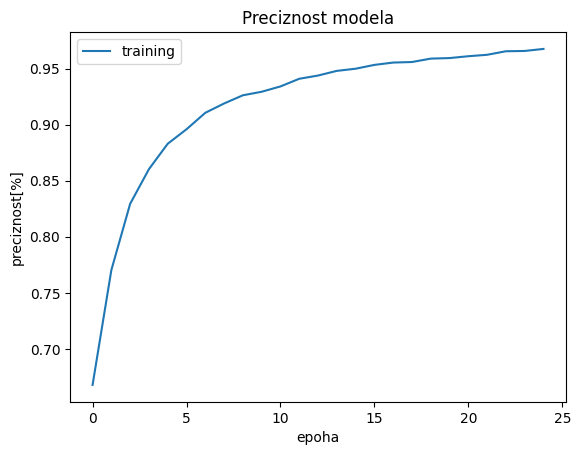

In [26]:
# Crtanje grafika preciznosti naspram borja epoha
plt.plot(history.history['acc'])
plt.title('Preciznost modela')
plt.ylabel('preciznost[%]')
plt.xlabel('epoha')
plt.legend(['training'], loc='best')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Na slici je pas sa sigurnošću od 93.22%.


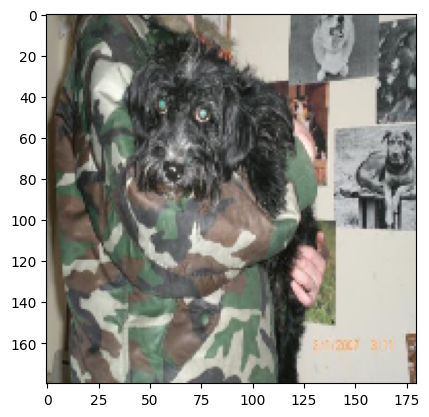

In [33]:
# Primer predviđanja
img = keras.utils.load_img("PetImages/Dog/10088.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
pet_is = "mačka" if score < 0.5 else "pas"
score = 100 * (1 - score) if score < 0.5 else 100 * score
print(f"Na slici je {pet_is} sa sigurnošću od {score:.2f}%.")

Како се не би сваки пут тренирао модел, сачуване су поставке неурона и могуће их је само учитати.

In [36]:
load_model = tf.keras.models.load_model('istreniran.keras')

# Prikaz da je arhitektura zaista ista
load_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 180, 180,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 90, 90,    │      3,584 │ rescaling[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 90, 90,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 90, 90,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 90, 90,    │          0 │ activation[0][0]  │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 90, 90,    │     34,176 │ activation_1[0][… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 90,    │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 90, 90,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 90, 90,    │     68,096 │ activation_2[0][… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 90,    │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 45, 45,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 45, 45,    │     33,024 │ activation[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 45, 45,    │          0 │ max_pooling2d[0]… │
│                     │ 256)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 45, 45,    │          0 │ add[0][0]         │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 45, 45,    │    133,888 │ activation_3[0][… │
│ (SeparableConv2D)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 45,    │      2,048 │ separable_conv2d

 Total params: 8,176,621 (31.19 MB)

 Trainable params: 2,722,777 (10.39 MB)

 Non-trainable params: 8,288 (32.38 KB)

 Optimizer params: 5,445,556 (20.77 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step
Na slici je pas sa sigurnošću od 93.22%.


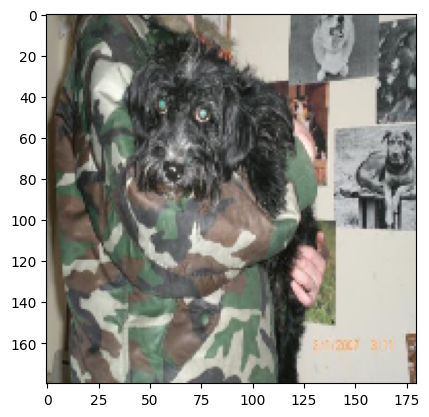

In [37]:
# Provera da li model još uvek predviđa kako treba
img = keras.utils.load_img("PetImages/Dog/10088.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)

predictions = load_model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
pet_is = "mačka" if score < 0.5 else "pas"
score = 100 * (1 - score) if score < 0.5 else 100 * score
print(f"Na slici je {pet_is} sa sigurnošću od {score:.2f}%.")